In [1]:
import numpy as np
import math
import sys
import time
import theano
import theano.tensor as T
import pystan
import matplotlib.pyplot as plt
import argparse
from scipy.stats import poisson
import matplotlib.patches as mpatches
from functools import partial
import pickle

nneuron = 61
min_angle = -90
max_angle = 90
sprefs = np.linspace(min_angle, max_angle, nneuron)
ndata = 3000
eps = np.finfo(np.float64).eps

r_max = 10
sigtc_sq = float(10**2)
sigtc = 10
c_50 = 13.1

In [8]:
def random_s(ndata, sort):
    s = np.random.rand(2, ndata) * 120 - 60
    if sort:
        s = np.sort(s, axis=0)
    return s[0], s[1]

def generate_trainset(ndata, r_max=10):
    s_0, s_1 = random_s(ndata, True)
    c_0, c_1 = np.ones((2, ndata)) * .5
    r, s, c = generate_popcode_data(ndata, nneuron, sigtc_sq, c_50, r_max, "poisson", True, s_0, s_1, c_0, c_1)
    return r, s, c

def generate_trainset_c(ndata, low=.3, high=.7, r_max=10):
    s_0, s_1 = random_s(ndata, True)
    c_0, c_1 = np.concatenate((np.ones((2, ndata/2)) * low, np.ones((2, ndata/2)) * high), axis=1)
    r, s, c = generate_popcode_data(ndata, nneuron, sigtc_sq, c_50, r_max, "poisson", True, s_0, s_1, c_0, c_1)
    return r, s, c

def generate_testset_c(ndata, low=.3, high=.7, r_max=10):
    s_0, s_1 = random_s(ndata, True)
    c_range = high - low
    c_0, c_1 = np.random.rand(2, ndata) * c_range + low
    r, s, c = generate_popcode_data(ndata, nneuron, sigtc_sq, c_50, r_max, "poisson", True, s_0, s_1, c_0, c_1)
    return r, s, c
    
def generate_popcode_data(ndata, nneuron, sigtc_sq, c_50, r_max, noise, sort, s_0, s_1, c_0, c_1):
    c_rms = np.sqrt(np.square(c_0) + np.square(c_1))
    sprefs_data = np.tile(sprefs, (ndata, 1))
    s_0t = np.exp(-np.square((np.transpose(np.tile(s_0, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_0 = c_0 * s_0t.T
    s_1t = np.exp(-np.square((np.transpose(np.tile(s_1, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_1 = c_1 * s_1t.T
    #r = r_max * (stim_0 + stim_1)/(c_50 + c_rms)
    r = r_max * (stim_0 + stim_1)
    r = r.T
    s = np.array((s_0, s_1)).T
    s = s/90
    c = np.array((c_0, c_1)).T
    if noise == "poisson":
        r = np.random.poisson(r) + 0.0
    return r, s, c

def generate_testset(stim_0, stim_1, ndata, con_0=.5, con_1=.5, constant_c=True, discrete_c=None, low=.5, high=.5, r_max=10):
    #c_0, c_1 = np.ones((2, ndata)) * .5
    if constant_c:
        c_0 = np.ones(ndata) * con_0
        c_1 = np.ones(ndata) * con_1
    else:
        c_range = high - low
        if discrete_c:
            cs = np.linspace(low, high, discrete_c)
            perm_cs = list(product(cs, cs))
            c_0, c_1 = np.repeat(perm_cs, ndata/(discrete_c**2), axis=0).T
            print ndata/(discrete_c**2), "trials per contrast level"
            if ndata%(discrete_c**2) != 0:
                print "Not divisible, only generated", ndata / (discrete_c**2) * (discrete_c**2), "trials"
            ndata = ndata / (discrete_c**2) * (discrete_c**2)
        else:
            c_0, c_1 = np.random.rand(2, ndata) * c_range + low
    s_0, s_1 = np.ones((2, ndata))
    s_0 = s_0 * stim_0
    s_1 = s_1 * stim_1
    r, s, c = generate_popcode_data(ndata, nneuron, sigtc_sq, c_50, r_max, "poisson", True, s_0, s_1, c_0, c_1)
    return r, s, c

def random_c(ndata, ndims, low, high, sort):
    c_range = high - low
    if ndims == 1:
        c = np.random.rand(ndims, ndata)[0] * c_range + low
    else:
        c = np.random.rand(ndims, ndata) * c_range + low
    if sort:
        c = np.sort(c, axis=0)
    return c

def generate_trainset_cat(ndata, low=.3, high=1.3, crange=.5, r_max=10):
    numvec = np.random.binomial(1, .5, size=ndata).astype(int)
    c_0 = random_c(ndata, 1, high, high+crange, True)
    c_1 = random_c(ndata, 1, low, low+crange, True)
    s_0, s_1 = np.random.rand(2, ndata) * 120 - 60
    r, numvec, s, c  = generate_popcode_data_cat(ndata, numvec, nneuron, sigtc_sq, c_50, r_max, "poisson", s_0, s_1, c_0, c_1)
    y = s[range(ndata), numvec]
    return r, y, s, c, numvec 
    
def generate_popcode_data_cat(ndata, numvec, nneuron, sigtc_sq, c_50, r_max, noise, s_0, s_1, c_0, c_1):
    c0vec = c_0 * np.ones(ndata)
    c1vec = c_1 * numvec
    c_rms = np.sqrt(np.square(c0vec) + np.square(c1vec))
    sprefs_data = np.tile(sprefs, (ndata, 1))
    s_0t = np.exp(-np.square((np.transpose(np.tile(s_0, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_0 = c0vec * s_0t.T
    s_1t = np.exp(-np.square((np.transpose(np.tile(s_1, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_1 = c1vec * s_1t.T
    #r = r_max * (stim_0 + stim_1)/(c_50 + c_rms)
    r = r_max * (stim_0 + stim_1)/(c_rms)
    #r = r_max * (stim_0 + stim_1)
    r = r.T
    s = np.array((s_0, s_1)).T
    s = s/90
    c = np.array((c_0, c_1)).T
    if noise == "poisson":
        r = np.random.poisson(r) + 0.0
    return r, numvec, s, c 

In [4]:
def cartesian(arrays, out=None):
    """Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """
    arrays = [np.asarray(x) for x in arrays]
    shape = (len(x) for x in arrays)
    dtype = arrays[0].dtype

    ix = np.indices(shape)
    ix = ix.reshape(len(arrays), -1).T

    if out is None:
        out = np.empty_like(ix, dtype=dtype)

    for n, arr in enumerate(arrays):
        out[:, n] = arrays[n][ix[:, n]]

    return out

In [5]:
neurons_code = """
    data {
        int<lower=0> N; // number of neurons
        int r[N]; // neural response
        real sprefs[N]; // preferred stimuli
        real<lower=0> c_1;
        real<lower=0> c_2;
        int r_max;
        //real c_rms;
        //real c_50;
        //real<lower=0> sig_tc;
        real<lower=0> sigtc_sq;
    }
    parameters {
        real s_1;
        //real s_2;
        real<lower=s_1> s_2;
    }
    transformed parameters {
        real lambda[N];
        for (n in 1:N)
            // lambda[n] <- r_max * ((c_1 * exp(normal_log(s_1, sprefs[n], sig_tc)) + c_2 * exp(normal_log(s_2, sprefs[n], sig_tc)))/(c_rms + c_50));
            // lambda[n] <- r_max * (c_1 * exp(normal_log(s_1, sprefs[n], sig_tc)) + c_2 * exp(normal_log(s_2, sprefs[n], sig_tc)));
            lambda[n] <- r_max * (c_1 * exp(- square(s_1 - sprefs[n])/(2 * sigtc_sq)) + c_2 * exp(- square(s_2 - sprefs[n])/(2 * sigtc_sq)));
    }
    model {
        s_1 ~ uniform(-60, 60);
        //s_2 ~ uniform(-60, 60);
        s_2 ~ uniform(s_1, 60);
        r ~ poisson(lambda);
    }
    """

In [6]:
def fisher_inf(s_0, s_1, c_0, c_1, r_max=10):
    fs_0 = np.exp(-np.square((np.transpose(np.tile(s_0, (nneuron, 1))) - sprefs))/(2 * sigtc_sq))[0]
    qs_0 = r_max * c_0 * fs_0
    df_s0 = ((-s_0 + sprefs)/sigtc_sq) * qs_0
    fs_1 = np.exp(-np.square((np.transpose(np.tile(s_1, (nneuron, 1))) - sprefs))/(2 * sigtc_sq))[0]
    qs_1 = r_max * c_1 * fs_1
    df_s1 = ((-s_1 + sprefs)/sigtc_sq) * qs_1
    Q = qs_0 + qs_1
    Q_inv = 1/Q
    J_11 = np.sum(np.square(df_s0) * Q_inv)
    J_22 = np.sum(np.square(df_s1) * Q_inv)
    J_12 = J_21 = np.sum(df_s0 * df_s1 * Q_inv)
    fisher = np.linalg.inv([[J_11, J_12], [J_21, J_22]])
    return fisher

def fit_optimal(r, sm, s=None, N=61, init=None, sprefs=sprefs, sampling=False, sort=False, c_1=[.5], c_2=[.5], c_50=13.1, r_max=10, c_rms=0.707106781, sig_tc=10, sigtc_sq=10**2):
    ndata = len(r)
    neurons_dat = {'N': 61,
                   'r': r[0].astype(int),
                   'sprefs': sprefs,
                   'c_1': c_1[0],
                   'c_2': c_1[0],
                   'c_50': 13.1,
                   'r_max': r_max,
                   'c_rms': 0.707106781,
                   'sig_tc': 10,
                   'sigtc_sq': sigtc_sq}

    optimal = np.zeros((2, ndata))
    print init
    for i in range(len(r)):
        neurons_dat['r'] = r[i].astype(int)
        if sampling:
            op = sm.sampling(data=neurons_dat)
            optimal[0][i], optimal[1][i] = np.mean(op['s_1']), np.mean(op['s_2'])
        else:
            if s:
                if s.any():
                    init = {'s_1':max(s[0][i], -60 + eps), 's_2':min(s[1][i] + eps, 60 - eps)}
                    print init
                    op = sm.optimizing(data=neurons_dat, init=init)
            elif not init:
                op = sm.optimizing(data=neurons_dat)
            else:     
                op = sm.optimizing(data=neurons_dat, init=init)
            optimal[0][i], optimal[1][i] = op['s_1'], op['s_2']
        if sort:
            optimal = np.sort(optimal, axis=0)
    return optimal

In [3]:
"""
Multilayer ReLU net
"""

def relu(x):
    return theano.tensor.switch(x<0, 0, x)

class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.nnet.sigmoid):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        :type rng: np.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input
        if W is None:
            W_values = (1/np.sqrt(n_in)) * np.random.randn(n_in, n_out)
            
            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]

class MLP(object):


    def __init__(self, rng, input, n_in, n_hidden, n_out):
        """Initialize the parameters for the multilayer perceptron

        :type rng: np.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
        architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
        which the datapoints lie

        :type n_hidden: int
        :param n_hidden: number of hidden units

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
        which the labels lie

        """

        self.hiddenLayer1 = HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_hidden,
            #activation=T.nnet.sigmoid
            activation=relu
        )
        
        self.hiddenLayer2 = HiddenLayer(
            rng=rng,
            input=self.hiddenLayer1.output,
            n_in=n_hidden,
            n_out=n_out,
            #activation=relu
            activation=None
        )
        
        self.y_pred = self.hiddenLayer2.output
        
        # the parameters of the model are the parameters of the two layers it is made out of
        self.params = self.hiddenLayer1.params + self.hiddenLayer2.params
    
    def get_params(self):

        params = {}
        for param in self.params:
            name = param.name
            if name in params:
                name = name, 2
            params[name] = param.get_value()
        return params
    
    def mse(self, y):
        # error between output and target
        if y.ndim == 1:
            se = (self.y_pred.T - y)**2
        else:
            se = T.sum((self.y_pred - y)**2, axis=1)
        return T.mean(se)
        
    
    def valid_mse(self, y):
        if y.ndim == 1:
            se = (self.y_pred.T * 90 - y * 90)**2
        else:
            se = T.sum((self.y_pred * 90 - y * 90)**2, axis=1)
        return T.mean(se)

    
class Perceptron(object):


    def __init__(self, rng, input, n_in, n_out):
        """Initialize the parameters for the multilayer perceptron

        :type rng: np.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
        architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
        which the datapoints lie

        :type n_hidden: int
        :param n_hidden: number of hidden units

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
        which the labels lie

        """

        self.layer = HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_out,
            #activation=T.nnet.sigmoid
            activation=relu
        )
        
        self.y_pred = self.layer.output
        
        # the parameters of the model are the parameters of the two layers it is made out of
        self.params = self.layer.params
        
    def get_params(self):

        params = {}
        for param in self.params:
            name = param.name
            if name in params:
                name = name, 2
            params[name] = param.get_value()
        return params
    
    def mse(self, y):
        # error between output and target
        if y.ndim == 1:
            se = (self.y_pred.T - y)**2
        else:
            se = T.sum((self.y_pred - y)**2, axis=1)
        return T.mean(se)
    
    def valid_mse(self, y):
        return mse(self, y)
        

def shared_dataset(data_xy, borrow=True, no_c=False):
        """ Function that loads the dataset into shared variables
        """
        data_x, data_y = data_xy[:2]
        shared_x = theano.shared(np.asarray(data_x,
                                               dtype='float32'),
                                 borrow=borrow)
        shared_y = theano.shared(np.asarray(data_y,
                                               dtype='float32'),
                                 borrow=borrow)
        return shared_x, shared_y

def train_nn(train_dataset, valid_dataset=None, n_hidden=20, learning_rate=0.01, n_epochs=10, batch_size=20, linear=False, mult_ys=True, rho=0, nesterov=True, momentum=0, n_in=61, n_out=2):
    """
    Demonstrate stochastic gradient descent optimization for a multilayer
    perceptron

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
    gradient

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer

   """
    train_set_x, train_set_y = shared_dataset(train_dataset)
    if valid_dataset:
        valid_set_x, valid_set_y = shared_dataset(valid_dataset)
    
    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] / batch_size
    
    
    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print '... building the model'

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.fmatrix('x')   # input data from visual neurons
    if n_out == 1:
        y = T.fvector('y') # ground truth
    else:
        y = T.fmatrix('y')  # ground truth

    rng = np.random.RandomState(1234)

    # construct the MLP class
    if linear:
        nn = Perceptron(rng=rng, input=x, n_in=n_in, n_out=n_out)
    else:
        nn = MLP(rng=rng, input=x, n_in=n_in, n_hidden=n_hidden, n_out=n_out)
    
    cost = nn.mse(y)
    
    def RMSprop(cost, params, learning_rate=0.001, rho=0.9, epsilon=1e-6, mu=0, nesterov=False):
        gparams = T.grad(cost, params)
        updates = []
        for p, g in zip(params, gparams):
            v = theano.shared(p.get_value() * 0.)
            ms = theano.shared(p.get_value() * 0.)
            ms_new = rho * ms + (1 - rho) * g ** 2
            gradient_scaling = T.sqrt(ms_new + epsilon)
            g = g / gradient_scaling
            """
            (1) v_t = mu * v_t-1 - lr * gradient_f(params_t)
            or
            classic
            (2) params_t = params_t-1 + v_t
            nesterov
            (7) params_t = params_t-1 + mu * v_t - lr * gradient_f(params_t-1)
            (8) params_t = params_t-1 + mu**2 * v_t-1 - (1+mu) * lr * gradient_f(params_t-1)
            """
            v_new = mu * v - (1 - mu) * learning_rate * g
            if nesterov:
                p_new = p + mu * v_new - (1 - mu) * learning_rate * g
            else:
                p_new = p + v_new
            updates.append((ms, ms_new))
            updates.append((v, v_new))
            updates.append((p, p_new))
                
        return updates
    
    if rho:
        updates = RMSprop(cost, nn.params, learning_rate=learning_rate, rho=rho, mu=momentum, nesterov=nesterov)
    else:
        # compute the gradient of cost with respect to theta (sotred in params)
        # the resulting gradients will be stored in a list gparams
        gparams = [T.grad(cost, param) for param in nn.params]

        # specify how to update the parameters of the model as a list of
        # (variable, update expression) pairs

        updates = [
            (param, param - learning_rate * gparam)
            for param, gparam in zip(nn.params, gparams)
        ]
    
    def inspect_inputs(i, node, fn):
        print i, node, "input(s) value(s):", [input[0] for input in fn.inputs]

    def inspect_outputs(i, node, fn):
        print "output(s) value(s):", [output[0] for output in fn.outputs]

    # compiling a Theano function `train_model` that returns the cost, but
    # in the same time updates the parameter of the model based on the rules
    # defined in `updates`
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    if mult_ys:
        valid_mse = nn.valid_mse(y)
    else:
        valid_mse = cost
    
    validate_model = theano.function(
        inputs=[index],
        outputs=valid_mse,
        givens={
            x: valid_set_x[index * batch_size:(index + 1) * batch_size],
            y: valid_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    ###############
    # TRAIN MODEL #
    ###############
    print '... training'

    start_time = time.clock()

    epoch = 0 
    done_looping = False
    
    if valid_dataset:
        valid_mse = np.zeros(n_epochs)

    while (epoch < n_epochs) and (not done_looping):
        for minibatch_index in xrange(n_train_batches):
            
            minibatch_avg_cost = train_model(minibatch_index)
            
        if valid_dataset:
            validation_losses = [validate_model(i) for i in xrange(n_valid_batches)]
            this_validation_loss = np.mean(validation_losses)
            valid_mse[epoch] = this_validation_loss
            print(
                'epoch %i, minibatch %i/%i, validation error %f' %
                (
                    epoch,
                    minibatch_index + 1,
                    n_train_batches,
                    this_validation_loss,
                )
            )
            
        epoch = epoch + 1

    end_time = time.clock()
    
    if valid_dataset:
        return nn, x, valid_mse
    return nn, x

def test_nn(nn, nnx, test_data):
    print 'testing'
    test_batch_size = 1
    test_set_x, test_set_y = shared_dataset(test_data)
    index = T.lscalar()  # index to a [mini]batch
    x = nnx   # input data from visual neurons
    test_model = theano.function(
        inputs=[index],
        outputs=nn.y_pred,
        givens={
            x: test_set_x[index * test_batch_size: (index + 1) * test_batch_size]
        },
    )
    
    true_ys = test_set_y.get_value()
    pred_ys = np.zeros((len(true_ys), 2))
    for i in range(len(true_ys)):
        pred_ys[i] = test_model(i)
        #print test_model(i)[0], true_ys[i]
        #print test_model(i)[0] * 90, true_ys[i]
    
    #print nn.get_params()
    return pred_ys, true_ys

In [417]:
#Setting up models
sm = pystan.StanModel(model_code=neurons_code)

In [4]:
train_data_1 = generate_trainset(20000)
valid_data_1 = generate_trainset(3000)
nn_rms, nnx_rms, valid_mse_rms = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, rho=.9)
"""
nn_rms_m9, nnx_rms_m9, valid_mse_rms_m9 = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, RMSProp=True, nesterov=True, momentum=0.9)
nn_rms_m9f, nnx_rms_m9f, valid_mse_rms_m9f = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, RMSProp=True, nesterov=False, momentum=0.9)
nn_rms_m95, nnx_rms_m95, valid_mse_rms_m95 = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, RMSProp=True, momentum=0.95)
nn_rms_m99, nnx_rms_m99, valid_mse_rms_m99 = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, RMSProp=True, momentum=0.99)
nn_plain, nnx_plain, valid_mse_plain = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100)
"""

... building the model
... training
epoch 0, minibatch 1000/1000, validation error 79.881078
epoch 1, minibatch 1000/1000, validation error 55.344328
epoch 2, minibatch 1000/1000, validation error 50.778865
epoch 3, minibatch 1000/1000, validation error 47.315433
epoch 4, minibatch 1000/1000, validation error 44.373741
epoch 5, minibatch 1000/1000, validation error 42.233018
epoch 6, minibatch 1000/1000, validation error 40.708483
epoch 7, minibatch 1000/1000, validation error 39.216748
epoch 8, minibatch 1000/1000, validation error 37.768709
epoch 9, minibatch 1000/1000, validation error 35.813594
epoch 10, minibatch 1000/1000, validation error 33.359844
epoch 11, minibatch 1000/1000, validation error 31.486596
epoch 12, minibatch 1000/1000, validation error 30.258163
epoch 13, minibatch 1000/1000, validation error 28.273343
epoch 14, minibatch 1000/1000, validation error 26.444802
epoch 15, minibatch 1000/1000, validation error 25.102450
epoch 16, minibatch 1000/1000, validation erro

'\nnn_rms_m9, nnx_rms_m9, valid_mse_rms_m9 = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, RMSProp=True, nesterov=True, momentum=0.9)\nnn_rms_m9f, nnx_rms_m9f, valid_mse_rms_m9f = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, RMSProp=True, nesterov=False, momentum=0.9)\nnn_rms_m95, nnx_rms_m95, valid_mse_rms_m95 = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, RMSProp=True, momentum=0.95)\nnn_rms_m99, nnx_rms_m99, valid_mse_rms_m99 = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, RMSProp=True, momentum=0.99)\nnn_plain, nnx_plain, valid_mse_plain = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100)\n'

In [6]:
def get_statistics(s1, s2, preds):
    mean_s1 = np.mean(preds[0])
    mean_s2 = np.mean(preds[1])
    bias_s1 = mean_s1 - s1
    bias_s2 = mean_s2 - s2
    covmat = np.cov(preds)
    var_s1 = covmat[0, 0]
    var_s2 = covmat[1, 1]
    cov = covmat[0, 1]
    corr = cov / (np.sqrt(var_s1) * np.sqrt(var_s2))
    stats = {'mean_s1': mean_s1, 'mean_s2': mean_s2, 'bias_s1': bias_s1, 'bias_s2': bias_s2, 'var_s1': var_s1, 'var_s2': var_s2, 'cov': cov, 'corr': corr}
    return stats

In [7]:
def lik_means(s_1, s_2, c_0=.5, c_1=.5, sprefs=sprefs, sigtc_sq=sigtc_sq):
    sprefs_data = np.tile(sprefs, (len(s_1), 1))
    s_0t = np.exp(-np.square((np.transpose(np.tile(s_1, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_0 = c_0 * s_0t.T
    s_1t = np.exp(-np.square((np.transpose(np.tile(s_2, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_1 = c_1 * s_1t.T
    r = r_max * (stim_0 + stim_1)
    return r.T
def posterior(r, means, s1_grid, s2_grid):
    ns_liks = poisson.pmf(r, mu=means)
    stim_liks = np.prod(ns_liks, axis=1)
    #p_s = 2/14400
    #logp_s = np.log(p_s)
    logp_s = -3.8573325
    loglik = np.sum(np.log(ns_liks), axis=1)
    mean1 = np.sum(s1_grid * np.exp(loglik + logp_s)/np.sum(np.exp(loglik + logp_s)))
    mean2 = np.sum(s2_grid * np.exp(loglik + logp_s)/np.sum(np.exp(loglik + logp_s)))
    expsquare1 = np.sum(np.square(s1_grid) * np.exp(loglik + logp_s)/np.sum(np.exp(loglik + logp_s)))
    expsquare2 = np.sum(np.square(s2_grid) * np.exp(loglik + logp_s)/np.sum(np.exp(loglik + logp_s)))
    var1 = expsquare1 - np.square(mean1)
    var2 = expsquare2 - np.square(mean2)
    return mean1, mean2, var1, var2
def posterior_setup(low=.3, high=.7, discrete_cs = 3, num_s=100):
    grid = np.linspace(-60, 60, num_s)
    s1s = np.concatenate([[grid[i]]*(num_s-i) for i in range(num_s)])
    cs = np.linspace(low, high, discrete_cs)
    s1_grid, c1_grid, c2_grid = cartesian((s1s, cs, cs)).T
    s2s = np.concatenate([grid[i:num_s+1] for i in range(num_s)])
    s2_grid = np.repeat(s2s, (discrete_cs**2), axis=0)
    means = lik_means(s1_grid, s2_grid, c_0=c1_grid, c_1=c2_grid)
    means2 = lik_means(s1s, s2s)
    partial_post = partial(posterior, means=means, s1_grid=s1_grid, s2_grid=s2_grid)
    return partial_post
def get_posteriors(r, post_func):
    posteriors = {'mean_s1': None, 'mean_s2': None, 'var_s1': None, 'var_s2': None}
    p = np.array([post_func(r[i]) for i in range(len(r))]).T
    posteriors['mean_s1'], posteriors['mean_s2'], posteriors['var_s1'], posteriors['var_s2'] = p
    return posteriors

In [218]:
#Timer stuff
def wrapper(func, *args, **kwargs):
    def wrapped():
         return func(*args, **kwargs)
    return wrapped

In [ ]:
rv, s, _ = valid_data_1
s=s.T*90
#opt_preds = fit_optimal(rv, sm, s)
post_preds = get_posteriors(rv)
#mse_opt = np.mean((opt_preds[0] - s[0]) ** 2 + (opt_preds[1] - s[1]) ** 2)
mse_post = np.mean((post_preds[0] - s[0]) ** 2 + (post_preds[1] - s[1]) ** 2)

In [ ]:
mse_opt = np.mean((opt_preds[0] - s[0]) ** 2 + (opt_preds[1] - s[1]) ** 2)
mse_post = np.mean((post_preds[0] - s[0]) ** 2 + (post_preds[1] - s[1]) ** 2)
print mse_opt, mse_post

In [ ]:
%matplotlib inline
#plt.plot(range(20, 100), valid_mse_plain[20:100], c='b')
#plt.plot(range(20, 100), valid_mse_rms[20:100], c='y')
plt.plot(valid_mse_plain, c='b', label='Vanilla')
plt.plot(valid_mse_rms, c='k', label='RMSProp')
plt.plot(np.ones(100) * mse_opt, c='m', label='MAP')
plt.plot(np.ones(100) * mse_post, c='orange', label='Posterior Mean')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE')

In [ ]:
s1 = -30
num_deltas = 60
#num_deltas = 5

mean_s1_nn_rms = [None] * num_deltas
mean_s2_nn_rms = [None] * num_deltas
bias_s1_nn_rms = [None] * num_deltas
bias_s2_nn_rms = [None] * num_deltas
var_s1_nn_rms = [None] * num_deltas
var_s2_nn_rms = [None] * num_deltas
corr_nn_rms = [None] * num_deltas
cov_nn_rms = [None] * num_deltas

"""
mean_s1_nn_rms_m9 = [None] * num_deltas
mean_s2_nn_rms_m9 = [None] * num_deltas
bias_s1_nn_rms_m9 = [None] * num_deltas
bias_s2_nn_rms_m9 = [None] * num_deltas
var_s1_nn_rms_m9 = [None] * num_deltas
var_s2_nn_rms_m9 = [None] * num_deltas
corr_nn_rms_m9 = [None] * num_deltas
cov_nn_rms_m9 = [None] * num_deltas

mean_s1_nn_rms_m9f = [None] * num_deltas
mean_s2_nn_rms_m9f = [None] * num_deltas
bias_s1_nn_rms_m9f = [None] * num_deltas
bias_s2_nn_rms_m9f = [None] * num_deltas
var_s1_nn_rms_m9f = [None] * num_deltas
var_s2_nn_rms_m9f = [None] * num_deltas
corr_nn_rms_m9f = [None] * num_deltas
cov_nn_rms_m9f = [None] * num_deltas

mean_s1_nn_rms_m95 = [None] * num_deltas
mean_s2_nn_rms_m95 = [None] * num_deltas
bias_s1_nn_rms_m95 = [None] * num_deltas
bias_s2_nn_rms_m95 = [None] * num_deltas
var_s1_nn_rms_m95 = [None] * num_deltas
var_s2_nn_rms_m95 = [None] * num_deltas
corr_nn_rms_m95 = [None] * num_deltas
cov_nn_rms_m95 = [None] * num_deltas

mean_s1_nn_rms_m99 = [None] * num_deltas
mean_s2_nn_rms_m99 = [None] * num_deltas
bias_s1_nn_rms_m99 = [None] * num_deltas
bias_s2_nn_rms_m99 = [None] * num_deltas
var_s1_nn_rms_m99 = [None] * num_deltas
var_s2_nn_rms_m99 = [None] * num_deltas
corr_nn_rms_m99 = [None] * num_deltas
cov_nn_rms_m99 = [None] * num_deltas

mean_s1_nn_plain = [None] * num_deltas
mean_s2_nn_plain = [None] * num_deltas
bias_s1_nn_plain = [None] * num_deltas
bias_s2_nn_plain = [None] * num_deltas
var_s1_nn_plain = [None] * num_deltas
var_s2_nn_plain = [None] * num_deltas
corr_nn_plain = [None] * num_deltas
cov_nn_plain = [None] * num_deltas
"""

mean_s1_opt = [None] * num_deltas
mean_s2_opt = [None] * num_deltas
bias_s1_opt = [None] * num_deltas
bias_s2_opt = [None] * num_deltas
var_s1_opt = [None] * num_deltas
var_s2_opt = [None] * num_deltas
corr_opt = [None] * num_deltas
cov_opt = [None] * num_deltas

mean_s1_post = [None] * num_deltas
mean_s2_post = [None] * num_deltas
bias_s1_post = [None] * num_deltas
bias_s2_post = [None] * num_deltas
var_s1_post = [None] * num_deltas
var_s2_post = [None] * num_deltas
corr_post = [None] * num_deltas
cov_post = [None] * num_deltas

var_s1_fisher = [None] * num_deltas
var_s2_fisher = [None] * num_deltas
cov_fisher = [None] * num_deltas

for delta_s in range(num_deltas):
    #test_data = generate_testset(s1, s1 + delta_s + 1, 3000)
    test_data = generate_testset(s1, s1 + delta_s, 300)
    nn_preds_rms, _ = test_nn(nn_rms, nnx_rms, test_data)
    """
    nn_preds_rms_m9, _ = test_nn(nn_rms_m9, nnx_rms_m9, test_data)
    nn_preds_rms_m9f, _ = test_nn(nn_rms_m9f, nnx_rms_m9f, test_data)
    nn_preds_rms_m95, _ = test_nn(nn_rms_m95, nnx_rms_m95, test_data)
    nn_preds_rms_m99, _ = test_nn(nn_rms_m99, nnx_rms_m99, test_data)
    nn_preds_plain, _ = test_nn(nn_plain, nnx_plain, test_data)
    """
    r, _, _ = test_data
    opt_preds = fit_optimal(r, sm, init={'s_1':s1, 's_2':s1 + delta_s + 1})
    post_preds = get_posteriors(r)
    
    nn_preds_rms = nn_preds_rms.T * 90
    """
    nn_preds_rms_m9 = nn_preds_rms_m9.T * 90
    nn_preds_rms_m9f = nn_preds_rms_m9f.T * 90
    nn_preds_rms_m95 = nn_preds_rms_m95.T * 90
    nn_preds_rms_m99 = nn_preds_rms_m99.T * 90
    nn_preds_plain = nn_preds_plain.T * 90
    """

    nn_stats_rms = get_statistics(s1, s1 + delta_s, nn_preds_rms)
    """
    nn_stats_rms_m9 = get_statistics(s1, s1 + delta_s, nn_preds_rms_m9)
    nn_stats_rms_m9f = get_statistics(s1, s1 + delta_s, nn_preds_rms_m9f)
    nn_stats_rms_m95 = get_statistics(s1, s1 + delta_s, nn_preds_rms_m95)
    nn_stats_rms_m99 = get_statistics(s1, s1 + delta_s, nn_preds_rms_m99)
    nn_stats_plain = get_statistics(s1, s1 + delta_s, nn_preds_plain)
    """
    opt_stats = get_statistics(s1, s1 + delta_s, opt_preds)
    post_stats = get_statistics(s1, s1 + delta_s, post_preds)
    
    if delta_s > 0:
        FI = fisher_inf(s1, s1 + delta_s, .5, .5)
        var_s1_fisher[delta_s] = FI[0, 0]
        var_s2_fisher[delta_s] = FI[1, 1]
        cov_fisher[delta_s] = FI[0, 1]
    
    mean_s1_nn_rms[delta_s] = nn_stats_rms['mean_s1']
    mean_s2_nn_rms[delta_s] = nn_stats_rms['mean_s2']
    bias_s1_nn_rms[delta_s] = nn_stats_rms['bias_s1']
    bias_s2_nn_rms[delta_s] = nn_stats_rms['bias_s2']
    var_s1_nn_rms[delta_s] = nn_stats_rms['var_s1']
    var_s2_nn_rms[delta_s] = nn_stats_rms['var_s2']
    corr_nn_rms[delta_s] = nn_stats_rms['corr']
    cov_nn_rms[delta_s] = nn_stats_rms['cov']
    
    mean_s1_opt[delta_s] = opt_stats['mean_s1']
    mean_s2_opt[delta_s] = opt_stats['mean_s2']
    bias_s1_opt[delta_s] = opt_stats['bias_s1']
    bias_s2_opt[delta_s] = opt_stats['bias_s2']
    var_s1_opt[delta_s] = opt_stats['var_s1']
    var_s2_opt[delta_s] = opt_stats['var_s2']
    corr_opt[delta_s] = opt_stats['corr']
    cov_opt[delta_s] = opt_stats['cov']
    
    mean_s1_post[delta_s] = post_stats['mean_s1']
    mean_s2_post[delta_s] = post_stats['mean_s2']
    bias_s1_post[delta_s] = post_stats['bias_s1']
    bias_s2_post[delta_s] = post_stats['bias_s2']
    var_s1_post[delta_s] = post_stats['var_s1']
    var_s2_post[delta_s] = post_stats['var_s2']
    corr_post[delta_s] = post_stats['corr']
    cov_post[delta_s] = post_stats['cov']
    
    """
    mean_s1_nn_rms_m9[delta_s] = nn_stats_rms_m9['mean_s1']
    mean_s2_nn_rms_m9[delta_s] = nn_stats_rms_m9['mean_s2']
    bias_s1_nn_rms_m9[delta_s] = nn_stats_rms_m9['bias_s1']
    bias_s2_nn_rms_m9[delta_s] = nn_stats_rms_m9['bias_s2']
    var_s1_nn_rms_m9[delta_s] = nn_stats_rms_m9['var_s1']
    var_s2_nn_rms_m9[delta_s] = nn_stats_rms_m9['var_s2']
    corr_nn_rms_m9[delta_s] = nn_stats_rms_m9['corr']
    cov_nn_rms_m9[delta_s] = nn_stats_rms_m9['cov']
    
    mean_s1_nn_rms_m9f[delta_s] = nn_stats_rms_m9f['mean_s1']
    mean_s2_nn_rms_m9f[delta_s] = nn_stats_rms_m9f['mean_s2']
    bias_s1_nn_rms_m9f[delta_s] = nn_stats_rms_m9f['bias_s1']
    bias_s2_nn_rms_m9f[delta_s] = nn_stats_rms_m9f['bias_s2']
    var_s1_nn_rms_m9f[delta_s] = nn_stats_rms_m9f['var_s1']
    var_s2_nn_rms_m9f[delta_s] = nn_stats_rms_m9f['var_s2']
    corr_nn_rms_m9f[delta_s] = nn_stats_rms_m9f['corr']
    cov_nn_rms_m9f[delta_s] = nn_stats_rms_m9f['cov']
    
    mean_s1_nn_rms_m95[delta_s] = nn_stats_rms_m95['mean_s1']
    mean_s2_nn_rms_m95[delta_s] = nn_stats_rms_m95['mean_s2']
    bias_s1_nn_rms_m95[delta_s] = nn_stats_rms_m95['bias_s1']
    bias_s2_nn_rms_m95[delta_s] = nn_stats_rms_m95['bias_s2']
    var_s1_nn_rms_m95[delta_s] = nn_stats_rms_m95['var_s1']
    var_s2_nn_rms_m95[delta_s] = nn_stats_rms_m95['var_s2']
    corr_nn_rms_m95[delta_s] = nn_stats_rms_m95['corr']
    cov_nn_rms_m95[delta_s] = nn_stats_rms_m95['cov']
    
    mean_s1_nn_rms_m99[delta_s] = nn_stats_rms_m99['mean_s1']
    mean_s2_nn_rms_m99[delta_s] = nn_stats_rms_m99['mean_s2']
    bias_s1_nn_rms_m99[delta_s] = nn_stats_rms_m99['bias_s1']
    bias_s2_nn_rms_m99[delta_s] = nn_stats_rms_m99['bias_s2']
    var_s1_nn_rms_m99[delta_s] = nn_stats_rms_m99['var_s1']
    var_s2_nn_rms_m99[delta_s] = nn_stats_rms_m99['var_s2']
    corr_nn_rms_m99[delta_s] = nn_stats_rms_m99['corr']
    cov_nn_rms_m99[delta_s] = nn_stats_rms_m99['cov']
    
    mean_s1_nn_plain[delta_s] = nn_stats_plain['mean_s1']
    mean_s2_nn_plain[delta_s] = nn_stats_plain['mean_s2']
    bias_s1_nn_plain[delta_s] = nn_stats_plain['bias_s1']
    bias_s2_nn_plain[delta_s] = nn_stats_plain['bias_s2']
    var_s1_nn_plain[delta_s] = nn_stats_plain['var_s1']
    var_s2_nn_plain[delta_s] = nn_stats_plain['var_s2']
    corr_nn_plain[delta_s] = nn_stats_plain['corr']
    cov_nn_plain[delta_s] = nn_stats_plain['cov']
    """

In [ ]:
%matplotlib inline
s = range(-30, 30)
neg_sd_nn_rms = mean_s1_nn_rms - np.sqrt(var_s1_nn_rms)
pos_sd_nn_rms = mean_s1_nn_rms + np.sqrt(var_s1_nn_rms)
neg_sd_opt = mean_s1_opt - np.sqrt(var_s1_opt)
pos_sd_opt = mean_s1_opt + np.sqrt(var_s1_opt)
neg_sd_post = mean_s1_post - np.sqrt(var_s1_post)
pos_sd_post = mean_s1_post + np.sqrt(var_s1_post)
plt.rc('text', usetex=True)
plt.figure(figsize=(10,10))
plt.fill_between(s, pos_sd_nn_rms, neg_sd_nn_rms, facecolor='k', alpha=0.5, edgecolor="None", label="NN")
plt.fill_between(s, pos_sd_opt, neg_sd_opt, facecolor='m', alpha=0.5, edgecolor="None", label="MLE")
plt.fill_between(s, pos_sd_post, neg_sd_post, facecolor='orange', alpha=0.5, edgecolor="None", label="Posterior")
plt.ylim([-40,40])
plt.xlabel(r'$s_2$',fontsize=30)
plt.ylabel(r'\hat{s_1}',fontsize=30)
nn_patch = mpatches.Patch(color='k', label='NN')
mle_patch = mpatches.Patch(color='m', label='MAP')
post_patch = mpatches.Patch(color='orange', label='Posterior')
plt.legend(handles=[nn_patch, mle_patch, post_patch])
plt.show()

In [ ]:
s = range(-30, 30)
neg_sd_nn_rms = mean_s2_nn_rms - np.sqrt(var_s2_nn_rms)
pos_sd_nn_rms = mean_s2_nn_rms + np.sqrt(var_s2_nn_rms)
neg_sd_opt = mean_s2_opt - np.sqrt(var_s2_opt)
pos_sd_opt = mean_s2_opt + np.sqrt(var_s2_opt)
neg_sd_post = mean_s2_post - np.sqrt(var_s2_post)
pos_sd_post = mean_s2_post + np.sqrt(var_s2_post)
plt.rc('text', usetex=True)
plt.figure(figsize=(10,10))
plt.fill_between(s, pos_sd_nn_rms, neg_sd_nn_rms, facecolor='k', alpha=0.5, edgecolor="None")
plt.fill_between(s, pos_sd_opt, neg_sd_opt, facecolor='m', alpha=0.5, edgecolor="None")
plt.fill_between(s, pos_sd_post, neg_sd_post, facecolor='orange', alpha=0.5, edgecolor="None")
plt.xlabel(r'$s_2$',fontsize=30)
plt.ylabel(r'\hat{s_2}',fontsize=30)
plt.ylim([-40,40])
plt.show()

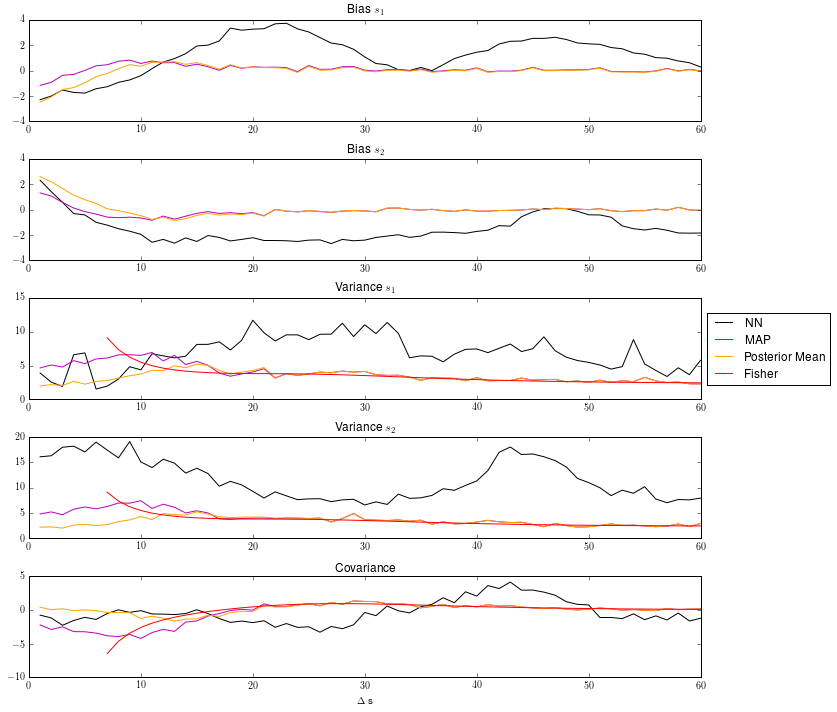

In [80]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
#RMS
ax1.plot(range(1, 61), bias_s1_nn_rms, c='k', label='NN')
ax2.plot(range(1, 61), bias_s2_nn_rms, c='k', label='NN')
ax3.plot(range(1, 61), var_s1_nn_rms, c='k', label='NN')
ax4.plot(range(1, 61), var_s2_nn_rms, c='k', label='NN')
ax5.plot(range(1, 61), cov_nn_rms, c='k', label='NN')
#optimal in red
ax1.plot(range(1, 61), bias_s1_opt, c='m', label='MAP')
ax2.plot(range(1, 61), bias_s2_opt, c='m', label='MAP')
ax3.plot(range(1, 61), var_s1_opt, c='m', label='MAP')
ax4.plot(range(1, 61), var_s2_opt, c='m', label='MAP')
ax5.plot(range(1, 61), cov_opt, c='m', label='MAP')
#optimal in red
ax1.plot(range(1, 61), bias_s1_post, c='orange', label='Posterior Mean')
ax2.plot(range(1, 61), bias_s2_post, c='orange', label='Posterior Mean')
ax3.plot(range(1, 61), var_s1_post, c='orange', label='Posterior Mean')
ax4.plot(range(1, 61), var_s2_post, c='orange', label='Posterior Mean')
ax5.plot(range(1, 61), cov_post, c='orange', label='Posterior Mean')
"""
#RMS with momentum
ax1.plot(range(1, 61), bias_s1_nn_rms_m9, c='m', label='NN')
ax2.plot(range(1, 61), bias_s2_nn_rms_m9, c='m', label='NN')
ax3.plot(range(1, 61), var_s1_nn_rms_m9, c='m', label='NN')
ax4.plot(range(1, 61), var_s2_nn_rms_m9, c='m', label='NN')
ax5.plot(range(1, 61), cov_nn_rms_m9, c='m', label='NN')
#RMS with momentum
ax1.plot(range(1, 61), bias_s1_nn_rms_m95, c='c', label='NN')
ax2.plot(range(1, 61), bias_s2_nn_rms_m95, c='c', label='NN')
ax3.plot(range(1, 61), var_s1_nn_rms_m95, c='c', label='NN')
ax4.plot(range(1, 61), var_s2_nn_rms_m95, c='c', label='NN')
ax5.plot(range(1, 61), cov_nn_rms_m95, c='c', label='NN')
#RMS with momentum
ax1.plot(range(1, 61), bias_s1_nn_rms_m99, c='k', label='NN')
ax2.plot(range(1, 61), bias_s2_nn_rms_m99, c='k', label='NN')
ax3.plot(range(1, 61), var_s1_nn_rms_m99, c='k', label='NN')
ax4.plot(range(1, 61), var_s2_nn_rms_m99, c='k', label='NN')
ax5.plot(range(1, 61), cov_nn_rms_m99, c='k', label='NN')
#RMS
ax1.plot(range(1, 61), bias_s1_nn_rms_m9f, c='r', label='NN')
ax2.plot(range(1, 61), bias_s2_nn_rms_m9f, c='r', label='NN')
ax3.plot(range(1, 61), var_s1_nn_rms_m9f, c='r', label='NN')
ax4.plot(range(1, 61), var_s2_nn_rms_m9f, c='r', label='NN')
ax5.plot(range(1, 61), cov_nn_rms_m9f, c='r', label='NN')
#Plain
ax1.plot(range(1, 61), bias_s1_nn_plain, c='b', label='NN')
ax2.plot(range(1, 61), bias_s2_nn_plain, c='b', label='NN')
ax3.plot(range(1, 61), var_s1_nn_plain, c='b', label='NN')
ax4.plot(range(1, 61), var_s2_nn_plain, c='b', label='NN')
ax5.plot(range(1, 61), cov_nn_plain, c='b', label='NN')
"""
#Fisher information in green
ax3.plot(range(7, 61), var_s1_fisher[6:60], c='r', label='Fisher')
ax4.plot(range(7, 61), var_s2_fisher[6:60], c='r', label='Fisher')
ax5.plot(range(7, 61), cov_fisher[6:60], c='r', label='Fisher')
ax1.locator_params(axis = 'y', nbins = 4)
ax2.locator_params(axis = 'y', nbins = 4)
ax3.locator_params(axis = 'y', nbins = 4)
ax4.locator_params(axis = 'y', nbins = 4)
ax5.locator_params(axis = 'y', nbins = 4)
#ax1.legend()
ax1.set_title("Bias $s_1$")
ax2.set_title("Bias $s_2$")
ax3.set_title(r'Variance $s_1$')
ax4.set_title(r'Variance $s_2$')
ax5.set_title('Covariance')
ax5.set_xlabel(r'$\Delta$ s')
f.set_size_inches(10,10)
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

In [ ]:
s1 = -30
num_deltas = 60
discrete_c = 3

mean_s1_nn_rms_c = [None] * num_deltas
mean_s2_nn_rms_c = [None] * num_deltas
bias_s1_nn_rms_c = [None] * num_deltas
bias_s2_nn_rms_c = [None] * num_deltas
var_s1_nn_rms_c = [None] * num_deltas
var_s2_nn_rms_c = [None] * num_deltas
corr_nn_rms_c = [None] * num_deltas
cov_nn_rms_c = [None] * num_deltas

mean_s1_opt_c = [None] * num_deltas
mean_s2_opt_c = [None] * num_deltas
bias_s1_opt_c = [None] * num_deltas
bias_s2_opt_c = [None] * num_deltas
var_s1_opt_c = [None] * num_deltas
var_s2_opt_c = [None] * num_deltas
corr_opt_c = [None] * num_deltas
cov_opt_c = [None] * num_deltas

mean_s1_post_c = [None] * num_deltas
mean_s2_post_c = [None] * num_deltas
bias_s1_post_c = [None] * num_deltas
bias_s2_post_c = [None] * num_deltas
var_s1_post_c = [None] * num_deltas
var_s2_post_c = [None] * num_deltas
corr_post_c = [None] * num_deltas
cov_post_c = [None] * num_deltas

var_s1_fisher_c = [None] * num_deltas
var_s2_fisher_c = [None] * num_deltas
cov_fisher_c = [None] * num_deltas

for delta_s in range(num_deltas):
    test_data = generate_testset(s1, s1 + delta_s, 3000, constant_c=False, discrete_c=discrete_c, low=.3, high=.7)
    nn_preds_rms, _ = test_nn(nn_rms, nnx_rms, test_data)
    r, _, _ = test_data
    #opt_preds = fit_optimal(r, sm, init={'s_1':s1, 's_2':s1 + delta_s + 1})
    #post_preds = get_posteriors(r)
    
    nn_preds_rms = nn_preds_rms.T * 90
    print nn_preds_rms.shape
    nn_stats_rms = get_statistics(s1, s1 + delta_s, nn_preds_rms)
    #opt_stats = get_statistics(s1, s1 + delta_s, opt_preds)
    #post_stats = get_statistics(s1, s1 + delta_s, post_preds)
    
    if delta_s > 0:
        FI = fisher_inf(s1, s1 + delta_s, .5, .5)
        var_s1_fisher_c[delta_s] = FI[0, 0]
        var_s2_fisher_c[delta_s] = FI[1, 1]
        cov_fisher_c[delta_s] = FI[0, 1]
    
    mean_s1_nn_rms_c[delta_s] = nn_stats_rms['mean_s1']
    mean_s2_nn_rms_c[delta_s] = nn_stats_rms['mean_s2']
    bias_s1_nn_rms_c[delta_s] = nn_stats_rms['bias_s1']
    bias_s2_nn_rms_c[delta_s] = nn_stats_rms['bias_s2']
    var_s1_nn_rms_c[delta_s] = nn_stats_rms['var_s1']
    var_s2_nn_rms_c[delta_s] = nn_stats_rms['var_s2']
    corr_nn_rms_c[delta_s] = nn_stats_rms['corr']
    cov_nn_rms_c[delta_s] = nn_stats_rms['cov']
    
    """
    mean_s1_opt_c[delta_s] = opt_stats['mean_s1']
    mean_s2_opt_c[delta_s] = opt_stats['mean_s2']
    bias_s1_opt_c[delta_s] = opt_stats['bias_s1']
    bias_s2_opt_c[delta_s] = opt_stats['bias_s2']
    var_s1_opt_c[delta_s] = opt_stats['var_s1']
    var_s2_opt_c[delta_s] = opt_stats['var_s2']
    corr_opt_c[delta_s] = opt_stats['corr']
    cov_opt_c[delta_s] = opt_stats['cov']
    """
    
    """
    mean_s1_post_c[delta_s] = post_stats['mean_s1']
    mean_s2_post_c[delta_s] = post_stats['mean_s2']
    bias_s1_post_c[delta_s] = post_stats['bias_s1']
    bias_s2_post_c[delta_s] = post_stats['bias_s2']
    var_s1_post_c[delta_s] = post_stats['var_s1']
    var_s2_post_c[delta_s] = post_stats['var_s2']
    corr_post_c[delta_s] = post_stats['corr']
    cov_post_c[delta_s] = post_stats['cov']
    """

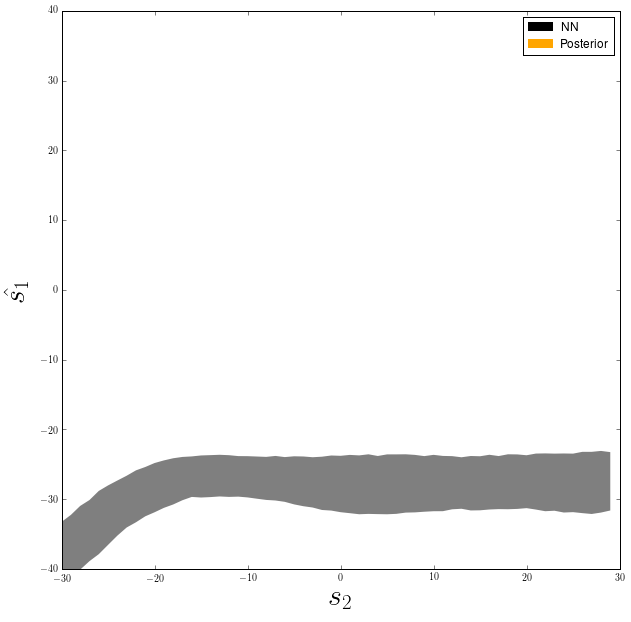

In [84]:
%matplotlib inline
s = range(-30, 30)
neg_sd_nn_rms_c = mean_s1_nn_rms_c - np.sqrt(var_s1_nn_rms_c)
pos_sd_nn_rms_c = mean_s1_nn_rms_c + np.sqrt(var_s1_nn_rms_c)
#neg_sd_post_c = mean_s1_post_c - np.sqrt(var_s1_post_c)
#pos_sd_post_c = mean_s1_post_c + np.sqrt(var_s1_post_c)
plt.rc('text', usetex=True)
plt.figure(figsize=(10,10))
plt.fill_between(s, pos_sd_nn_rms_c, neg_sd_nn_rms_c, facecolor='k', alpha=0.5, edgecolor="None", label="NN")
#plt.fill_between(s, pos_sd_post_c, neg_sd_post_c, facecolor='orange', alpha=0.5, edgecolor="None", label="Posterior")
plt.ylim([-40,40])
plt.xlabel(r'$s_2$',fontsize=30)
plt.ylabel(r'\hat{s_1}',fontsize=30)
nn_patch = mpatches.Patch(color='k', label='NN')
post_patch = mpatches.Patch(color='orange', label='Posterior')
plt.legend(handles=[nn_patch, post_patch])
plt.show()

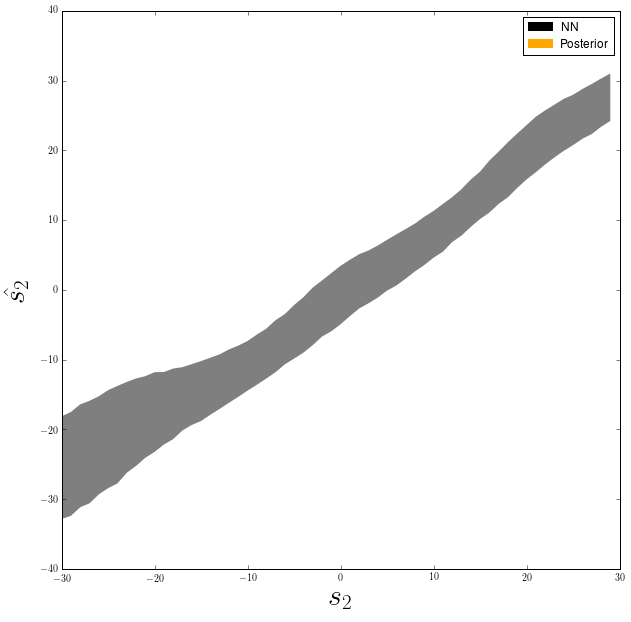

In [85]:
%matplotlib inline
s = range(-30, 30)
neg_sd_nn_rms_c = mean_s2_nn_rms_c - np.sqrt(var_s2_nn_rms_c)
pos_sd_nn_rms_c = mean_s2_nn_rms_c + np.sqrt(var_s2_nn_rms_c)
#neg_sd_post_c = mean_s2_post_c - np.sqrt(var_s2_post_c)
#pos_sd_post_c = mean_s2_post_c + np.sqrt(var_s2_post_c)
plt.rc('text', usetex=True)
plt.figure(figsize=(10,10))
plt.fill_between(s, pos_sd_nn_rms_c, neg_sd_nn_rms_c, facecolor='k', alpha=0.5, edgecolor="None", label="NN")
#plt.fill_between(s, pos_sd_post_c, neg_sd_post_c, facecolor='orange', alpha=0.5, edgecolor="None", label="Posterior")
plt.ylim([-40,40])
plt.xlabel(r'$s_2$',fontsize=30)
plt.ylabel(r'\hat{s_2}',fontsize=30)
nn_patch = mpatches.Patch(color='k', label='NN')
post_patch = mpatches.Patch(color='orange', label='Posterior')
plt.legend(handles=[nn_patch, post_patch])
plt.show()

In [ ]:
s1 = -30
num_deltas = 60
discrete_c = 3
ndata = 3000
ndata_per_c = ndata/(discrete_c**2)

mean_s1_nn_rms_c = np.zeros((num_deltas, discrete_c**2))
mean_s2_nn_rms_c = np.zeros((num_deltas, discrete_c**2))
bias_s1_nn_rms_c = np.zeros((num_deltas, discrete_c**2))
bias_s2_nn_rms_c = np.zeros((num_deltas, discrete_c**2))
var_s1_nn_rms_c = np.zeros((num_deltas, discrete_c**2))
var_s2_nn_rms_c = np.zeros((num_deltas, discrete_c**2))
corr_nn_rms_c = np.zeros((num_deltas, discrete_c**2))
cov_nn_rms_c = np.zeros((num_deltas, discrete_c**2))

for delta_s in range(num_deltas):
    test_data = generate_testset(s1, s1 + delta_s, 3000, constant_c=False, discrete_c=discrete_c, low=.3, high=.7)
    nn_preds_rms, _ = test_nn(nn_rms, nnx_rms, test_data)
    print len(nn_preds_rms)
    for c in range(discrete_c**2):
        nn_preds_c = nn_preds_rms[(ndata_per_c*c):(ndata_per_c*(c+1))].T * 90
        nn_stats = get_statistics(s1, s1 + delta_s, nn_preds_c)
    
        mean_s1_nn_rms_c[delta_s][c] = nn_stats['mean_s1']
        mean_s2_nn_rms_c[delta_s][c] = nn_stats['mean_s2']
        bias_s1_nn_rms_c[delta_s][c] = nn_stats['bias_s1']
        bias_s2_nn_rms_c[delta_s][c] = nn_stats['bias_s2']
        var_s1_nn_rms_c[delta_s][c] = nn_stats['var_s1']
        var_s2_nn_rms_c[delta_s][c] = nn_stats['var_s2']
        corr_nn_rms_c[delta_s][c] = nn_stats['corr']
        cov_nn_rms_c[delta_s][c] = nn_stats['cov']

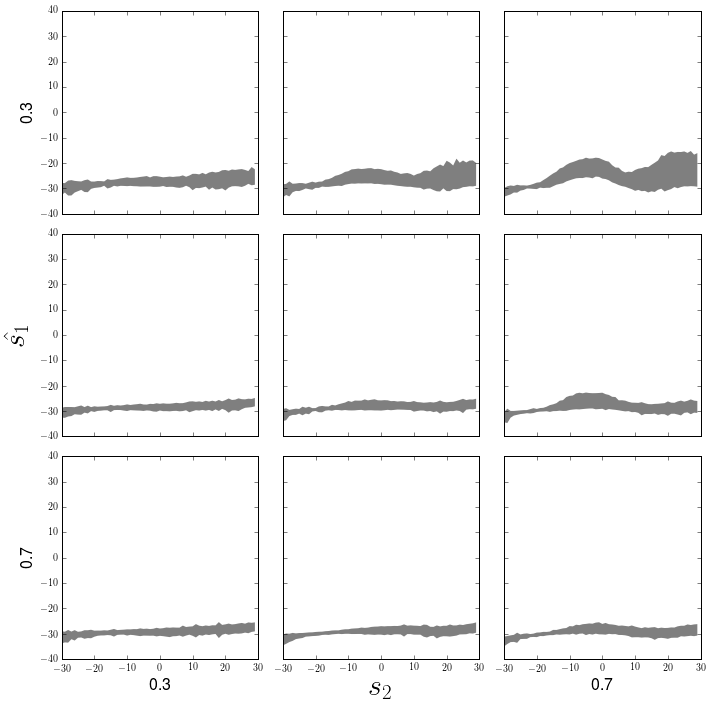

In [20]:
%matplotlib inline
s = range(-30, 30)
f, ax = plt.subplots(3, 3, sharex=True, sharey=True)
plt.rc('text', usetex=True)
plt.ylim([-40,40])
for c in range(discrete_c**2):
    x, y = c/discrete_c, c%discrete_c
    neg_sd_nn_rms_c = mean_s1_nn_rms_c[:, c] - np.sqrt(var_s1_nn_rms_c[:, c])
    pos_sd_nn_rms_c = mean_s1_nn_rms_c[:, c] + np.sqrt(var_s1_nn_rms_c[:, c])
    ax[x, y].fill_between(s, pos_sd_nn_rms_c, neg_sd_nn_rms_c, facecolor='k', alpha=0.5, edgecolor="None", label="NN")
ax[2, 1].set_xlabel(r'$s_2$',fontsize=30)
ax[1, 0].set_ylabel(r'$\hat{s_1}$',fontsize=30)
ax[2, 0].set_xlabel(.3, fontsize=16)
ax[2, 2].set_xlabel(.7, fontsize=16)
ax[0, 0].set_ylabel(.3, fontsize=16)
ax[2, 0].set_ylabel(.7, fontsize=16)
f.set_size_inches(10,10)
plt.tight_layout()

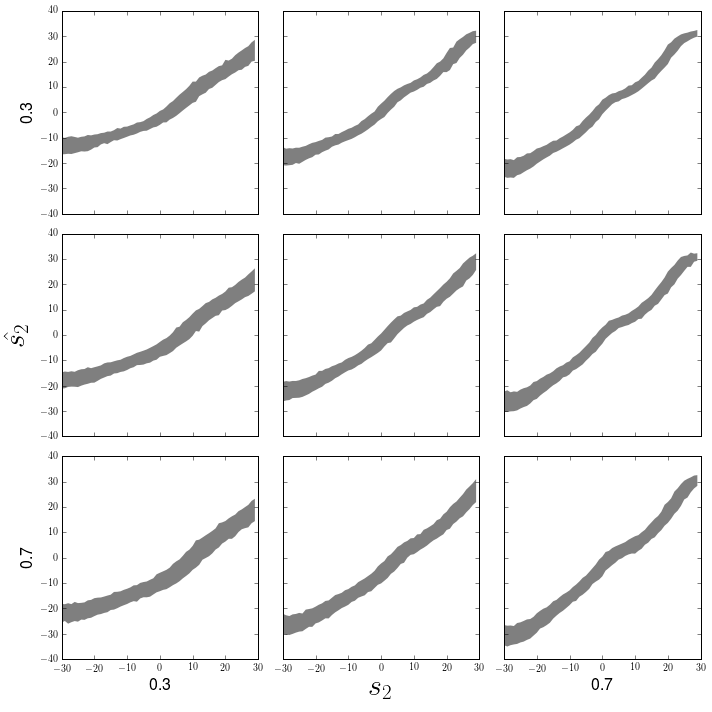

In [22]:
%matplotlib inline
s = range(-30, 30)
f, ax = plt.subplots(3, 3, sharex=True, sharey=True)
plt.rc('text', usetex=True)
plt.ylim([-40,40])
for c in range(discrete_c**2):
    x, y = c/discrete_c, c%discrete_c
    neg_sd_nn_rms_c = mean_s2_nn_rms_c[:, c] - np.sqrt(var_s2_nn_rms_c[:, c])
    pos_sd_nn_rms_c = mean_s2_nn_rms_c[:, c] + np.sqrt(var_s2_nn_rms_c[:, c])
    ax[x, y].fill_between(s, pos_sd_nn_rms_c, neg_sd_nn_rms_c, facecolor='k', alpha=0.5, edgecolor="None", label="NN")
ax[2, 1].set_xlabel(r'$s_2$',fontsize=30)
ax[1, 0].set_ylabel(r'$\hat{s_2}$',fontsize=30)
ax[2, 0].set_xlabel(.3, fontsize=16)
ax[2, 2].set_xlabel(.7, fontsize=16)
ax[0, 0].set_ylabel(.3, fontsize=16)
ax[2, 0].set_ylabel(.7, fontsize=16)
f.set_size_inches(10,10)
plt.tight_layout()

In [606]:
train_data_1 = generate_testset_c(20000, low=.3, high=.7, r_max=10)
valid_data_1 = generate_testset_c(3000, low=.3, high=.7, r_max=10)
nn_rms, nnx_rms, valid_mse_rms = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, rho=.9)

... building the model
... training
epoch 0, minibatch 1000/1000, validation error 884.940878
epoch 1, minibatch 1000/1000, validation error 307.545496
epoch 2, minibatch 1000/1000, validation error 197.699331
epoch 3, minibatch 1000/1000, validation error 167.946841
epoch 4, minibatch 1000/1000, validation error 150.560399
epoch 5, minibatch 1000/1000, validation error 144.263363
epoch 6, minibatch 1000/1000, validation error 138.548074
epoch 7, minibatch 1000/1000, validation error 134.471451
epoch 8, minibatch 1000/1000, validation error 131.545686
epoch 9, minibatch 1000/1000, validation error 131.101048
epoch 10, minibatch 1000/1000, validation error 126.756808
epoch 11, minibatch 1000/1000, validation error 122.140717
epoch 12, minibatch 1000/1000, validation error 118.213983
epoch 13, minibatch 1000/1000, validation error 114.823593
epoch 14, minibatch 1000/1000, validation error 109.409354
epoch 15, minibatch 1000/1000, validation error 107.711672
epoch 16, minibatch 1000/1000,

'\nnn_rms_m9, nnx_rms_m9, valid_mse_rms_m9 = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, RMSProp=True, nesterov=True, momentum=0.9)\nnn_rms_m9f, nnx_rms_m9f, valid_mse_rms_m9f = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, RMSProp=True, nesterov=False, momentum=0.9)\nnn_rms_m95, nnx_rms_m95, valid_mse_rms_m95 = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, RMSProp=True, momentum=0.95)\nnn_rms_m99, nnx_rms_m99, valid_mse_rms_m99 = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100, RMSProp=True, momentum=0.99)\nnn_plain, nnx_plain, valid_mse_plain = train_nn(train_data_1, valid_dataset=valid_data_1, n_hidden=20, learning_rate=.001, n_epochs=100)\n'

In [10]:
td_cat = generate_trainset_cat(20000, low=.3, high=1.3, crange=.5, r_max=10)
vd_cat = generate_trainset_cat(3000, low=.3, high=1.3, crange=.5, r_max=10)
nn_cat, nnx_cat, valid_mse_cat = train_nn(td_cat, valid_dataset=vd_cat, n_hidden=20, learning_rate=.0005, n_epochs=100, rho=.9, n_out=1)

... building the model
... training
epoch 0, minibatch 1000/1000, validation error 296.741335
epoch 1, minibatch 1000/1000, validation error 157.865943
epoch 2, minibatch 1000/1000, validation error 113.841213
epoch 3, minibatch 1000/1000, validation error 96.188692
epoch 4, minibatch 1000/1000, validation error 87.103458
epoch 5, minibatch 1000/1000, validation error 80.150219
epoch 6, minibatch 1000/1000, validation error 74.349906
epoch 7, minibatch 1000/1000, validation error 70.069090
epoch 8, minibatch 1000/1000, validation error 67.060473
epoch 9, minibatch 1000/1000, validation error 64.512964
epoch 10, minibatch 1000/1000, validation error 61.967347
epoch 11, minibatch 1000/1000, validation error 59.946692
epoch 12, minibatch 1000/1000, validation error 57.985563
epoch 13, minibatch 1000/1000, validation error 56.208661
epoch 14, minibatch 1000/1000, validation error 55.115865
epoch 15, minibatch 1000/1000, validation error 54.394552
epoch 16, minibatch 1000/1000, validation e

In [290]:
def python_relu(x):
    return x * (x > 0)

def get_hu_responses(r, nn):
    nn_params = nn.get_params()
    b = nn_params['b']
    W = nn_params['W']
    trials = python_relu(np.dot(r, W) + b)
    return trials

def post_trainset(r, nn, post_func):
    x = get_hu_responses(r, nn)
    posts = get_posteriors(r, post_func)
    y = np.array((1/posts['var_s1'], 1/posts['var_s2']))
    return x, y

In [607]:
post_func = posterior_setup(low=.3, high=.7, discrete_cs = 3, num_s=50)
r, s, c = generate_testset_c(20000, low=.3, high=.7)
vr, vs, vc = generate_testset_c(3000, low=.3, high=.7)
hlr, post = post_trainset(r, nn_rms, post_func)
print "valid"
vhlr, vpost = post_trainset(vr, nn_rms, post_func)

valid


In [611]:
nn_post, nnx_post, valid_mse_post = train_nn((hlr, post.T), valid_dataset=(vhlr, vpost.T), n_in=20, learning_rate=.0005, n_epochs=100, linear=True, rho=.9)

... building the model
... training
epoch 0, minibatch 1000/1000, validation error 2.372175
epoch 1, minibatch 1000/1000, validation error 2.358988
epoch 2, minibatch 1000/1000, validation error 2.349509
epoch 3, minibatch 1000/1000, validation error 2.339812
epoch 4, minibatch 1000/1000, validation error 2.331897
epoch 5, minibatch 1000/1000, validation error 2.289369
epoch 6, minibatch 1000/1000, validation error 2.270379
epoch 7, minibatch 1000/1000, validation error 2.256452
epoch 8, minibatch 1000/1000, validation error 2.248523
epoch 9, minibatch 1000/1000, validation error 2.242993
epoch 10, minibatch 1000/1000, validation error 2.238145
epoch 11, minibatch 1000/1000, validation error 2.196388
epoch 12, minibatch 1000/1000, validation error 2.130023
epoch 13, minibatch 1000/1000, validation error 2.119584
epoch 14, minibatch 1000/1000, validation error 2.117731
epoch 15, minibatch 1000/1000, validation error 2.117674
epoch 16, minibatch 1000/1000, validation error 2.118089
epoch

In [707]:
nn_post2, nnx_post2, valid_mse_post2 = train_nn((r, post.T, c), valid_dataset=(vr, vpost.T, vc), n_hidden=20, mult_ys=False, learning_rate=.001, n_epochs=100, rho=.9)

... building the model
... training
epoch 0, minibatch 1000/1000, validation error 2.130340
epoch 1, minibatch 1000/1000, validation error 2.111543
epoch 2, minibatch 1000/1000, validation error 2.098052
epoch 3, minibatch 1000/1000, validation error 2.089184
epoch 4, minibatch 1000/1000, validation error 2.083401
epoch 5, minibatch 1000/1000, validation error 2.080662
epoch 6, minibatch 1000/1000, validation error 2.077869
epoch 7, minibatch 1000/1000, validation error 2.073667
epoch 8, minibatch 1000/1000, validation error 2.068342
epoch 9, minibatch 1000/1000, validation error 2.063797
epoch 10, minibatch 1000/1000, validation error 2.062146
epoch 11, minibatch 1000/1000, validation error 2.059281
epoch 12, minibatch 1000/1000, validation error 2.057262
epoch 13, minibatch 1000/1000, validation error 2.054726
epoch 14, minibatch 1000/1000, validation error 2.053013
epoch 15, minibatch 1000/1000, validation error 2.051088
epoch 16, minibatch 1000/1000, validation error 2.049515
epoch

[[ 1.          0.56338575  0.68753593  0.65191239]
 [ 0.56338575  1.          0.66555875  0.66876598]
 [ 0.68753593  0.66555875  1.          0.9723839 ]
 [ 0.65191239  0.66876598  0.9723839   1.        ]]


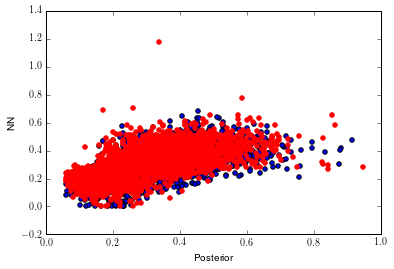

In [612]:
%matplotlib inline
hus = get_hu_responses(vr, nn_rms)
nn_posts1 = get_hu_responses(hus, nn_post)
vpost_sel = np.all(vpost<1, axis=0)
vp = np.array((vpost[0][vpost_sel], vpost[1][vpost_sel]))
np1 = np.array((nn_posts1.T[0][vpost_sel], nn_posts1.T[1][vpost_sel]))
plt.scatter(vp[0], np1[0])
plt.scatter(vp[1], np1[1], color='r')
plt.xlim(0, 1)
plt.xlabel("Posterior")
plt.ylabel("NN")
print np.corrcoef(vp, np1)

[[ 1.          0.04835099  0.23191664  0.21247859]
 [ 0.04835099  1.          0.2260445   0.25116495]
 [ 0.23191664  0.2260445   1.          0.94615678]
 [ 0.21247859  0.25116495  0.94615678  1.        ]]


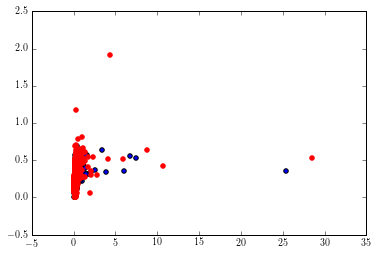

In [616]:
plt.scatter(vpost[0], nn_posts1.T[0])
plt.scatter(vpost[1], nn_posts1.T[1], color='r')
print np.corrcoef(vpost, nn_posts1.T)

testing
[[ 1.          0.56338575  0.80094762  0.4731615 ]
 [ 0.56338575  1.          0.57389712  0.6734174 ]
 [ 0.80094762  0.57389712  1.          0.45892857]
 [ 0.4731615   0.6734174   0.45892857  1.        ]]
[[ 1.          0.80094762]
 [ 0.80094762  1.        ]]


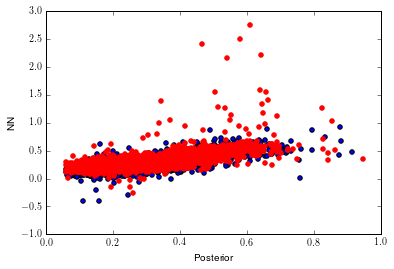

In [714]:
%matplotlib inline
nn_posts2, _ = test_nn(nn_post2, nnx_post2, (vr, vpost.T, vc))
nn_posts2 = nn_posts2.T
vpost_sel = np.all(vpost<1, axis=0)
vp = np.array((vpost[0][vpost_sel], vpost[1][vpost_sel]))
np2 = np.array((nn_posts2[0][vpost_sel], nn_posts2[1][vpost_sel]))
plt.scatter(vp[0], np2[0])
plt.scatter(vp[1], np2[1], color='r')
plt.xlim(0, 1)
plt.xlabel("Posterior")
plt.ylabel("NN")
print np.corrcoef(vp, np2)
print np.corrcoef(vp[0], np2[0])

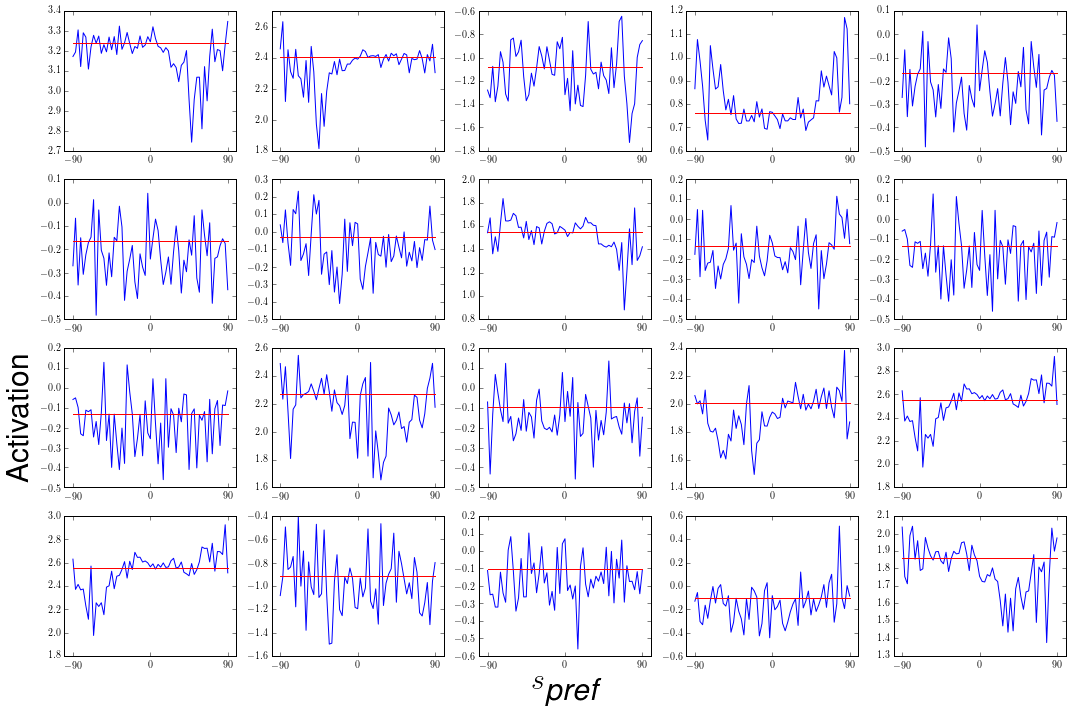

In [618]:
f, axarr = plt.subplots(4, 5)
xticks = [-90, 0, 90]
for i in range(4):
    for j in range(5):
        ind = i * 4 + j
        axarr[i, j].plot(sprefs, nn_rms.get_params()['W'].T[ind] + nn_rms.get_params()['b'][ind])
        axarr[i, j].plot(sprefs, np.ones(61) * nn_rms.get_params()['b'][ind], color = 'r')
        axarr[i, j].set_xticks(xticks)
axarr[2, 0].set_ylabel("Activation" ,fontsize=30)
axarr[3, 2].set_xlabel(r'$s_{\textit{pref}}$', fontsize=30)
f.set_size_inches(15,10)
plt.tight_layout()

In [672]:
def get_mean_acts(s_arr, nn):
    l_sarr = len(s_arr)
    acts = np.zeros((l_sarr, l_sarr, 20))
    for i in range(l_sarr):
        for j in range(i+1, l_sarr):
            s1 = s_arr[i]
            s2 = s_arr[j]
            r, s, c = generate_testset(s1, s2, 300, low=.3, high=.7, constant_c=False, discrete_c=3)
            acts[i][j] = np.mean(get_hu_responses(r, nn), axis=0)
    return np.array(acts)

In [683]:
s_arr = [-50, -30, -10, 0, 10, 30, 50]
acts = get_mean_acts(s_arr, nn_rms)

33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contra

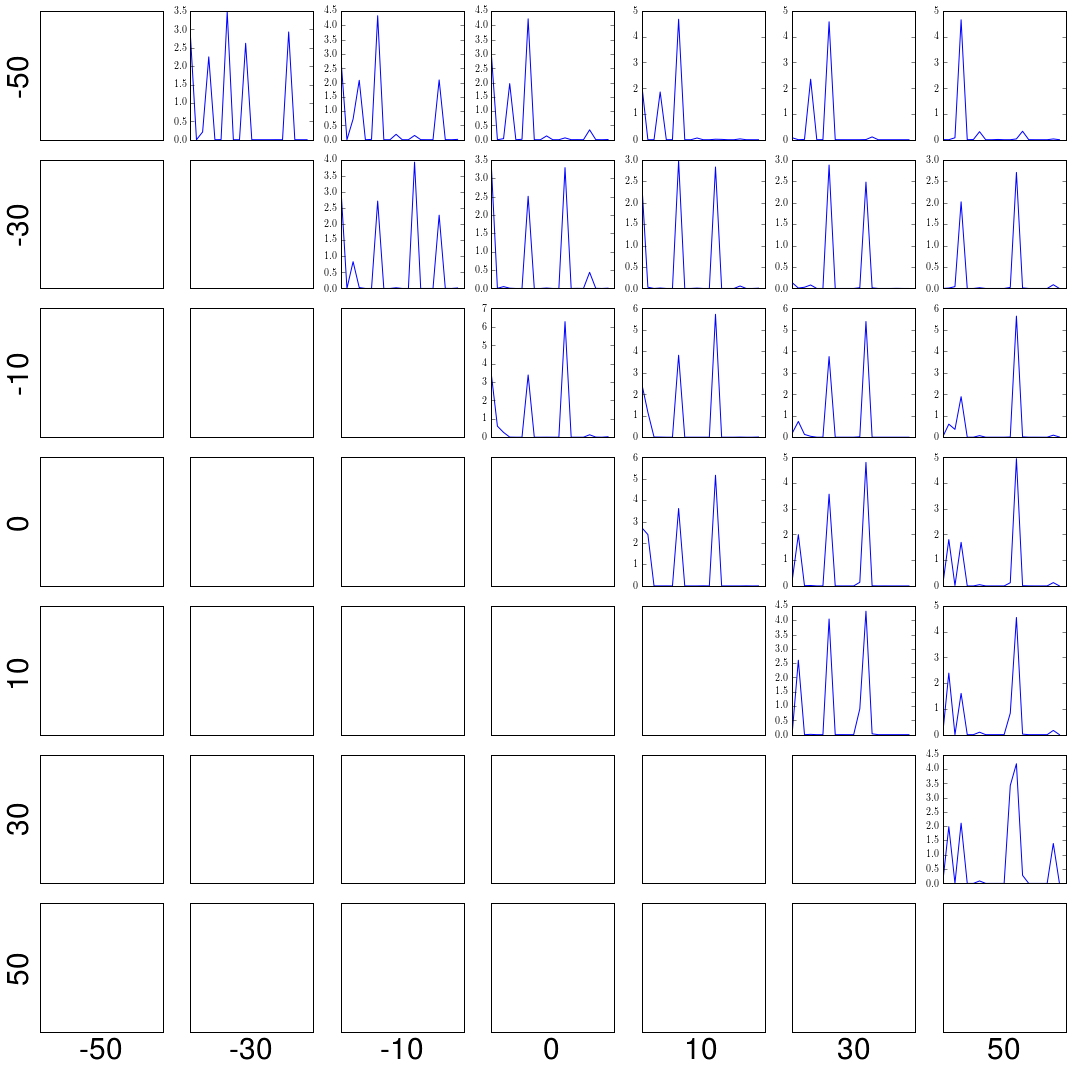

In [656]:
l_sarr = len(s_arr)
f, axarr = plt.subplots(l_sarr, l_sarr)
for i in range(l_sarr):
    for j in range(i+1, l_sarr):
        for k in range(i+1):
            axarr[i, k].xaxis.set_visible(False)
            axarr[i, k].set_yticks([])
        axarr[i, j].plot(acts[i][j])
        axarr[i, j].xaxis.set_visible(False)
    axarr[i, 0].set_ylabel(s_arr[i] ,fontsize=30)
for l in range(l_sarr):
    axarr[l_sarr-1, l].set_xlabel(s_arr[l] ,fontsize=30)
    axarr[l_sarr-1, l].set_xticks([])
    axarr[l_sarr-1, l].set_yticks([])
f.set_size_inches(15,15)
plt.tight_layout()

In [ ]:
s_arr = np.linspace(-60, 60, 120)
acts = get_mean_acts(s_arr, nn_rms)

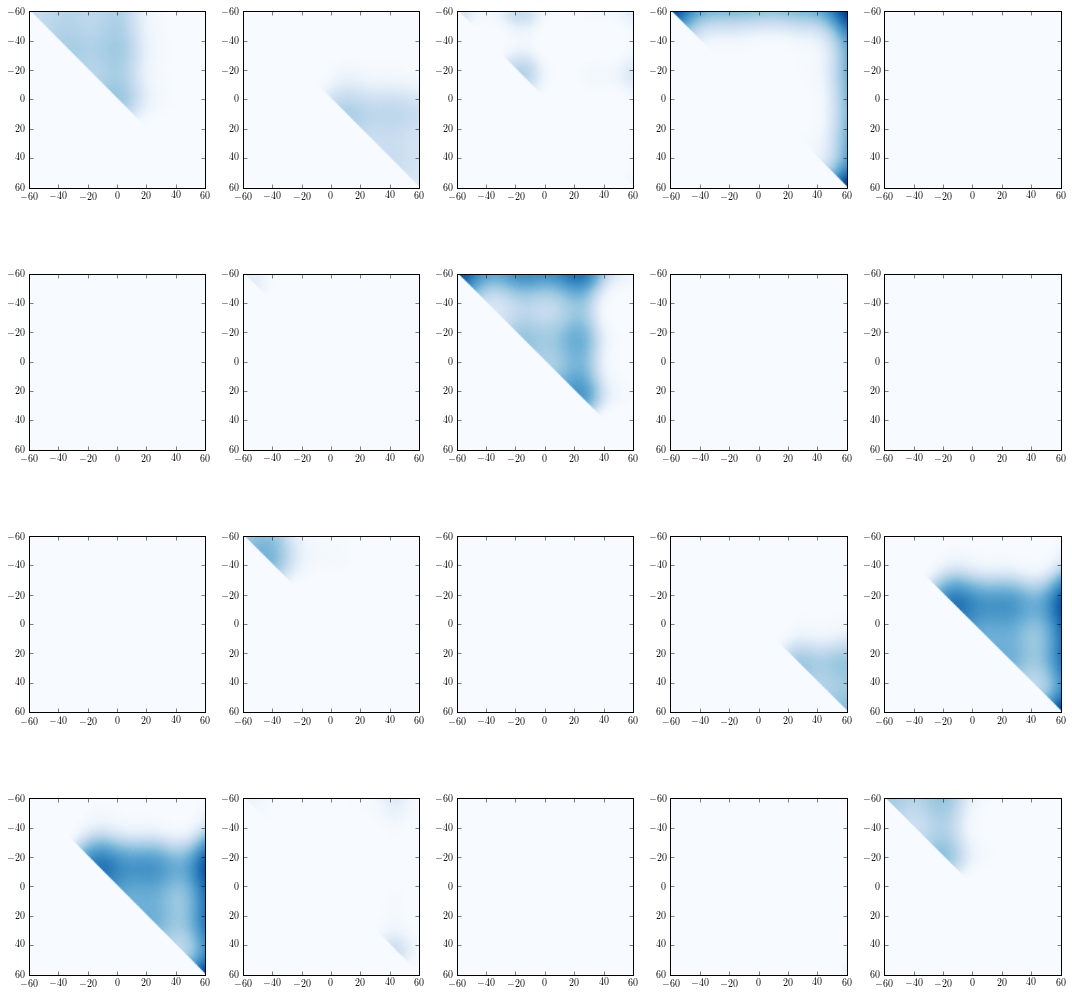

In [701]:
f, axarr = plt.subplots(4, 5)
for i in range(4):
    for j in range(5):
        ind = i * 4 + j
        axarr[i,j].imshow(acts[:, :, ind], cmap="Blues", vmax=np.max(acts), extent=(-60, 60, 60, -60))
        #axarr[i,j].imshow(acts[:, :, ind], cmap="Blues", extent=(-60, 60, 60, -60))
f.set_size_inches(15,15)
plt.tight_layout()

In [401]:
rs1_ = np.insert(vr, 0, vpost[0], axis=1)
rs1 = rs1_[rs1_[:, 0].argsort()]
sorted_r1 = rs1[:, 1:62]